In [1]:
%pylab inline
import skrf as rf # scikit-rf : object-oriented approach to microwave engineering

Populating the interactive namespace from numpy and matplotlib


Importing home-made classes.

In [2]:
from resonant_loop import ResonantLoop, ResonantDoubleLoop
from TOPICA import TopicaResult

In [55]:
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 16, 12  # increase the default image size 

# Importing the full-wave solutions

We import the three devices of our electric circuit: the bridge, the impedance transformer and the window. As the default frequency range defined in skrf is the GHz, we set the frequency unit to MHz (this is only in order to have nicer plot after).  

In [56]:
bridge = rf.io.hfss_touchstone_2_network('../Notebooks/WEST_ICRH/WEST_ICRH_final_bridge_impedance-trans_WEST-final-bridge-only.s3p', f_unit='MHz')
impedance_transformer = rf.io.hfss_touchstone_2_network('../Notebooks/WEST_ICRH/WEST_ICRH_final_bridge_impedance-trans_WEST-final-impedance-transformer.s2p', f_unit='MHz')
window = rf.io.hfss_touchstone_2_network('../Notebooks/WEST_ICRH/WEST_ICRH_final_bridge_impedance-trans_WEST-final-window.s2p', f_unit='MHz')

# Single Resonant Loop

Here we create a single resonant loop, and match it on a manually created plasma.

In [4]:
RL1 = ResonantLoop(bridge, impedance_transformer, window)
RL1.get_network() # look at the port char impedance to see if everything is fine

3-Port Network: 'WEST_ICRH_final_bridge_impedance-trans_WEST-final-window',  40-60 MHz, 201 pts, z0=[ 29.73896504+0.j          13.68468209-0.00334742j  13.68647445-0.0033458j ]

Set the capacitors to dummy values and plot the S11 for example.

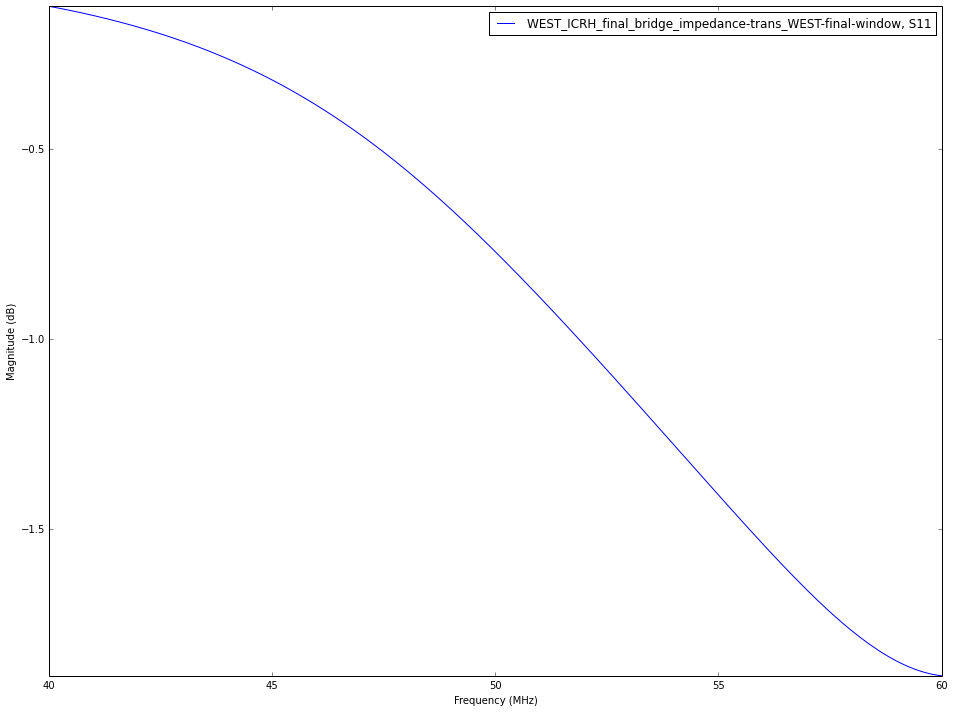

In [57]:
RL1.set_capacitors([60e-12, 60e-12])
RL1.load(1+30*1j).plot_s_db()

## Matching the single resonant loop

In [6]:
sol_single_RDL = RL1.match(f_match=48e6, z_load=1+30*1j)

Load the bridge with the capacitor values found:

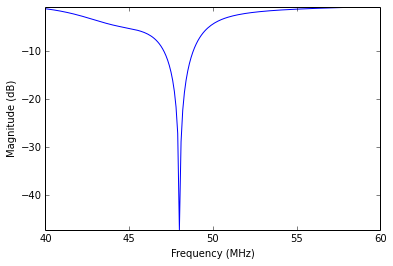

In [7]:
RL1.set_capacitors(sol_single_RDL.x)
RL1.load(1+30*1j).plot_s_db(show_legend=False)

# Resonant Double Loop

We assume here that the bridge, impedance transformer and window are the same for both resonant loop.

In [8]:
RL1 = ResonantLoop(bridge, impedance_transformer, window, name='RL1')
RL2 = ResonantLoop(bridge, impedance_transformer, window, name='RL2')
RL1.get_network() # port 0 is 30 Ohm input, ports 1 & 2 bridge outputs

3-Port Network: 'WEST_ICRH_final_bridge_impedance-trans_WEST-final-window',  40-60 MHz, 201 pts, z0=[ 29.73896504+0.j          13.68468209-0.00334742j  13.68647445-0.0033458j ]

Let's create an antenna with uncoupled staps (in poloidal and toroidal)

In [9]:
Z_simple1 = 1+30*1j
Z_simple2 = 1+30*1j
# The Z matrix ports indexing follows TOPICA convention, that is indexes strap 1 and 3, and 2 and 4
# create a diagonal Z-matrix
Z_matrix_simple = np.diag([Z_simple1, Z_simple2, Z_simple1, Z_simple2])

# creating the associated network
plasma = rf.Network(s=rf.z2s(np.tile(Z_matrix_simple,(len(bridge.frequency),1,1)), z0=[13,13,13,13]))
plasma.frequency = bridge.frequency
plasma.z0 = [13.7,13.7,13.7,13.7]
plasma

4-Port Network: '',  40-60 MHz, 201 pts, z0=[ 13.7+0.j  13.7+0.j  13.7+0.j  13.7+0.j]

Creating a resonant double loop antenna loaded with the above plasma.

In [10]:
%load_ext autoreload
%autoreload 2

In [11]:
RDL = ResonantDoubleLoop(RL1, RL2, plasma)

Set the capacitors of the antenna do dummy values and plot the Sii for example.

/home/hash/Documents/Python/Modules/skrf/skrf/mathFunctions.py:165: RuntimeWarning: divide by zero encountered in log10
  out = 20 * npy.log10(input)


2-Port Network: 'antenna',  40-60 MHz, 201 pts, z0=[ 29.73896504+0.j  29.73896504+0.j]

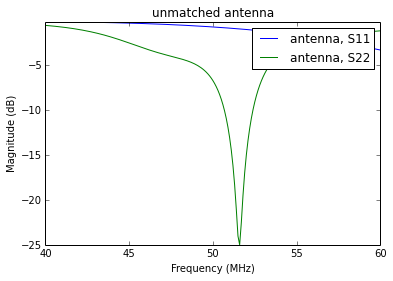

In [14]:
RDL.set_capacitors([50e-12, 60e-12, 70e-12, 80e-12])
antenna = RDL.get_network()
antenna.plot_s_db(m=0, n=0)
antenna.plot_s_db(m=1, n=1)
title('unmatched antenna')
antenna

## Matching the resonant double loop antenna

In [17]:
f_match = 48e6
Z_match = [30+1j*0, 30+1j*0]
a_in = [1, -1]

sol_simple = RDL.match(a_in, f_match, Z_match)

True [ 76.61602025  87.84372533  87.84600752  76.60957193]
[ 76.61602025  87.84372533  87.84600752  76.60957193]


Test how good is the solution that has been found. 

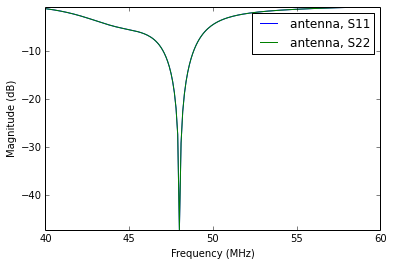

In [18]:
RDL.set_capacitors(sol_simple.x)
antenna = RDL.get_network()
antenna.plot_s_db(m=0,n=0)
antenna.plot_s_db(m=1,n=1)


[40, 60, 1, 10]

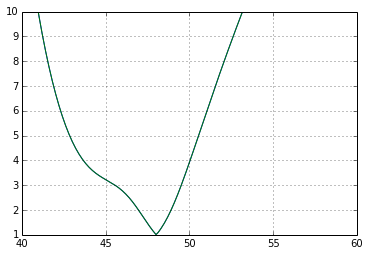

In [23]:
plot(RDL.get_f()/1e6, RDL.get_vswr_active([1,-1]))
grid()
axis([40, 60, 1, 10])

# TOPICA Matrix

In [25]:
def TOPICA_2_network(filename):
    proto9 = TopicaResult(filename, z0=9.2)
    # we re-set the characteristic impedance in order to match the bridge characteric impedance
    # TODO: for future TOPICA results, check that the CAD model characteristic impedance is coherent with the bridge model used. 
    proto9.z0 = [RL1.z0[1], RL1.z0[2], RL1.z0[1], RL1.z0[2]]
    proto9.z0 = [13.7,13.7,13.7,13.7]
    plasma_TOPICA = proto9.to_skrf_network(bridge.frequency, name='plasma')
    return(plasma_TOPICA)

I've also created a function that write a Touchstone file from TOPICA matrix.

In [26]:
#proto9.write_touchstone('TOPICA_TSproto9_Profile1.s4p', RL1.network.frequency, name='TOPICA profile#1')

Here we connect a TOPICA coupling matrix to two resonant loops. Pay attention to the way TOPICA indexes the straps. 
$$\begin{matrix}
2 & | & 1 \\
4 & | & 3
\end{matrix}$$
cf figure below

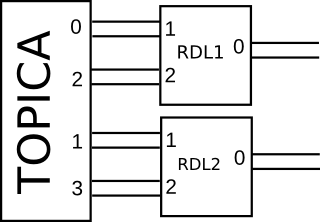

In [64]:
from IPython.display import Image
Image('network.png')

In [65]:
plasma_TOPICA = TOPICA_2_network('WEST_ICRH/TOPICA/Zs_TSproto9_Profile1.txt')
f_match = 48e6
Z_match = [30+1j*0, 30+1j*0]
a_in = [1, -1]

RDL = ResonantDoubleLoop(RL1, RL2, plasma_TOPICA)

sol_TOPICA = RDL.match(a_in, f_match, Z_match)

False [  7.75151481e+01   6.28620555e+01  -3.38500702e+05   6.38901382e+01]
Bad solution found (out of range capacitor) ! Re-doing...
False [    67.1685727      71.07899666     68.64961037 -26091.4246303 ]
Bad solution found (out of range capacitor) ! Re-doing...
False [  9.72523533e+01   6.33389943e+01   6.88082284e+01  -2.30902859e+07]
Bad solution found (out of range capacitor) ! Re-doing...
False [  6.83349542e+01  -6.40103297e+16   7.80721998e+01   6.26442438e+01]
Bad solution found (out of range capacitor) ! Re-doing...
False [  6.83106043e+01   8.97823984e+09   7.69215841e+01   6.26909595e+01]
Bad solution found (out of range capacitor) ! Re-doing...
False [   68.43508544 -2186.49218051    67.50589327    71.28835255]
Bad solution found (out of range capacitor) ! Re-doing...
False [ -3.91342025e+06   6.39137736e+01   6.72282230e+01   7.06619915e+01]
Bad solution found (out of range capacitor) ! Re-doing...
False [  2.37312247e+02   6.36974651e+01   6.88013983e+01  -1.25921886e+05

/usr/lib64/python2.7/site-packages/scipy/optimize/minpack.py:236: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


For the same set of capacitor values found, we vary the plasma load and plot scattering parameters and VSWR

[40, 60, -50, 0]

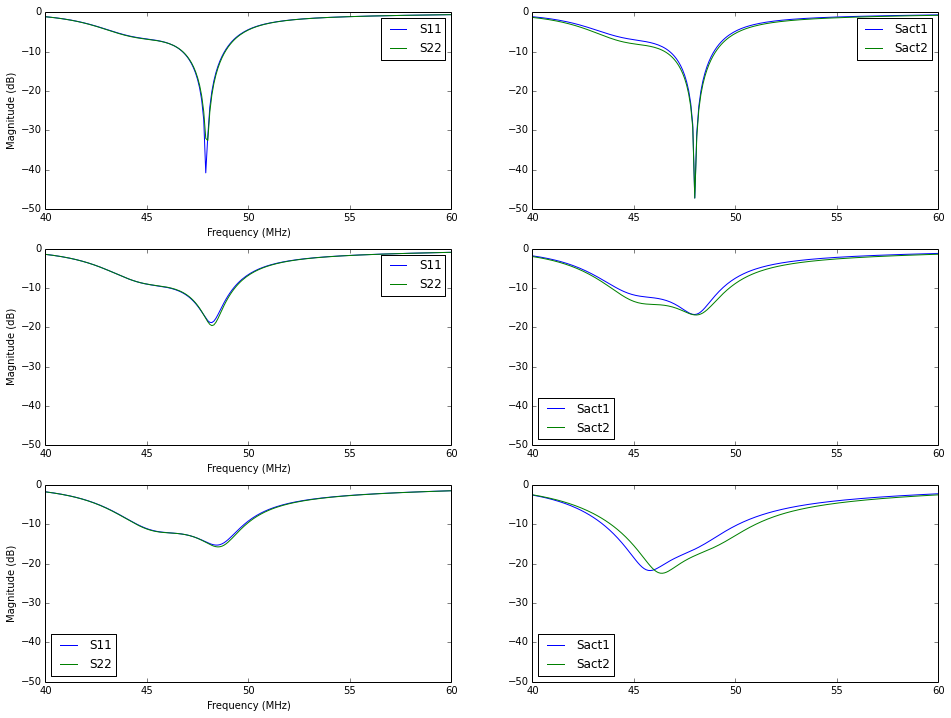

In [66]:
RDL.plasma = TOPICA_2_network('WEST_ICRH/TOPICA/Zs_TSproto9_Profile1.txt')

subplot(321)
RDL.get_network().plot_s_db(m=0,n=0)
RDL.get_network().plot_s_db(m=1,n=1)
axis([40,60,-50,0])
legend(('S11', 'S22'),loc='best')
subplot(322)
plot(RDL.get_f()/1e6, 20*np.log10(np.abs(RDL.get_s_active(a_in))))
legend(('Sact1', 'Sact2'),loc='best')
axis([40,60,-50,0])

RDL.plasma = TOPICA_2_network('WEST_ICRH/TOPICA/Zs_TSproto9_Profile4.txt')

subplot(323)
RDL.get_network().plot_s_db(m=0,n=0)
RDL.get_network().plot_s_db(m=1,n=1)
axis([40,60,-50,0])
legend(('S11', 'S22'),loc='best')
subplot(324)
plot(RDL.get_f()/1e6, 20*np.log10(np.abs(RDL.get_s_active(a_in))))
legend(('Sact1', 'Sact2'),loc='best')
axis([40,60,-50,0])

RDL.plasma = TOPICA_2_network('WEST_ICRH/TOPICA/Zs_TSproto9_Profile8.txt')

subplot(325)
RDL.get_network().plot_s_db(m=0,n=0)
RDL.get_network().plot_s_db(m=1,n=1)
axis([40,60,-50,0])
legend(('S11', 'S22'),loc='best')
subplot(326)
plot(RDL.get_f()/1e6, 20*np.log10(np.abs(RDL.get_s_active(a_in))))
legend(('Sact1', 'Sact2'),loc='best')
axis([40,60,-50,0])


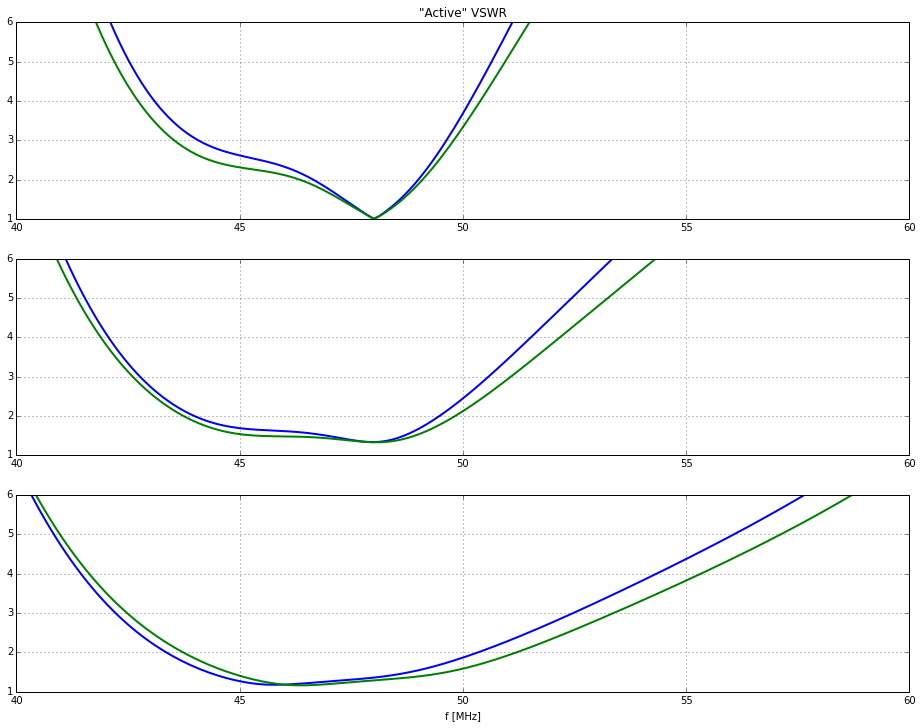

In [68]:
RDL.plasma = TOPICA_2_network('WEST_ICRH/TOPICA/Zs_TSproto9_Profile1.txt')
subplot(311)
plot(RDL.get_f()/1e6, RDL.get_vswr_active(a_in), lw=2)
axis([40,60,1,6])
grid()
title('"Active" VSWR')

RDL.plasma = TOPICA_2_network('WEST_ICRH/TOPICA/Zs_TSproto9_Profile4.txt')
subplot(312)
plot(RDL.get_f()/1e6, RDL.get_vswr_active(a_in), lw=2)
axis([40,60,1,6])
grid()

RDL.plasma = TOPICA_2_network('WEST_ICRH/TOPICA/Zs_TSproto9_Profile8.txt')
subplot(313)
plot(RDL.get_f()/1e6, RDL.get_vswr_active(a_in), lw=2)
axis([40,60,1,6])
grid()
xlabel('f [MHz]')
